# Actividad 2: Convolutional Neural Networks

## Integrantes:
- Diana Marcela Romero Córdova
- Johanna Lorena Sánchez Castro
- José Daniel Báez Maldonado
- Daniel David Proaño Guevara
- Santiago Felipe Luna Romero

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Carga de los datos

In [0]:
import cv2
import os
import numpy as np 
import keras
import matplotlib.pyplot as plt
import glob


# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

Using TensorFlow backend.


10665984/10658925 [==============================] - 1s 0us/step


In [0]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [0]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [0]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [0]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [0]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

## Entregable

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

## **Análisis de los datos a utilizar**


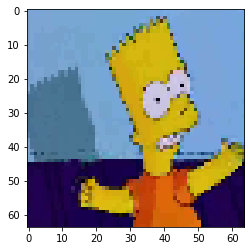

In [0]:
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB))
plt.show()

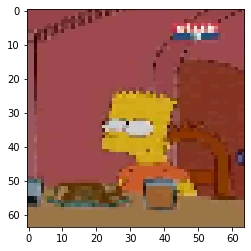

In [0]:
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(X[2], cv2.COLOR_BGR2RGB))
plt.show()

El dataset de entrenamiento consta de un total de 18992 imagenes en color, con un tamaño de 64 pixels de ancho por 64 pixels de alto, tenemos 3 canales, que son: R(red), G(green) y B(blue). El dataset de prueba consta de un total de 890 imagenes en color y sus imagenes tienen el mismo tamaño que las imagenes del dataset de entrenamiento

## **Entrenamiento del modelo CNN**

Se realizaron pruebas con distintos modelos de redes neuronales convolucionales CNN variando las capas que se utilizan hasta llegar al modelo final con los resultados deseados, manteniendo un tamaño de batch de 128, 15 épocas y un 20% del dataset para validación.

Se entrenó inicialente una red con la siguiente arquitectura, obteniendo una accuracy de entrenamiento cercana al 98% y de validación alrededor del 70%:
- Capa Convolucional, 32 filtros 3x3
- Capa Convolucional, 64 filtros 3x3
- Capa MaxPooling, filtro 2x2
- Capa Dropout 0.5
- Capa Densa softmax

Debido a que esta red tenía poca capacidad de generalización al caer en overfitting, se añadió una capa densa junto con una capa Dropout adicional para regularizarla antes de la capa final, y se obtuvieron resultados de accuracy alrededor de 90% en entrenamiento y 75% en validación.

Al observar que los resultados no eran los esperados, se procedió a añadir dos capas convolucionales adicionales con mayor número de filtros junto con otra capa MaxPooling y otra Dropout, y se redujo el número de épocas a 12, obteniendo el siguiente modelo:

- Capa Convolucional, 32 filtros 3x3
- Capa Convolucional, 64 filtros 3x3
- Capa MaxPooling, filtro 2x2
- Capa Dropout 0.5
- Capa Convolucional, 128 filtros 3x3
- Capa Convolucional, 256 filtros 3x3
- Capa MaxPooling, filtro 2x2
- Capa Dropout 0.5
- Capa Densa, 128 neuronas
- Capa Dropout 0.5
- Capa Densa softmax

Entrenando este modelo se obtuvo una accuracy de entrenamiento del 85% y de validación de 84%. Al observar que estos resultados eran cercanos al objetivo de 85% de accuracy, se procedió a evaluar el modelo con los datos de test, obteniendo una accuracy de test cercana al 93%.

La construcción y entrenamiento de este modelo final, cuyos resultados fueron satisfactorios, se muestra a continuación.

Entre las pruebas adicionales que se hicieron, se añadió a este modelo dos capas convolucionales, se utilizó un mayor número de filtros por cada capa, se utilizó el optimizador Adam; sin embargo, ninguna de estas variantes presentó mejores resultados.

**Funciones para comparar visualmente los resultados**

In [0]:
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

**Importamos los modelos que vamos a utilizar**

In [0]:
#import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
#import tensorflow as tf

#import matplotlib
#import matplotlib.pyplot as plt

**Establecemos algunas variables e hiperparámetros**

In [0]:
num_clases = 18
input_shape = X.shape[1:]
print("Input shape:", input_shape)

batch_size = 128
epochs = 30

Input shape: (64, 64, 3)


**Preprocesamiento de los datos**

In [0]:
# Normalizamos los valores de entrada
X = X / 255.0
X_t = X_t / 255.0
X = X.astype('float32')
X_t = X_t.astype('float32')

# Subdividimos los datos de entrada en train y validation
# Tomamos el ultimo 20% de datos como validation 
X_val = X[-round(y.size*0.2):,:,:,:]
y_val = y[-round(y.size*0.2):]

X_train = X[:round(y.size*0.8),:,:,:]
y_train = y[:round(y.size*0.8)]

print(X_train.shape)
print(y_train.shape)

labels=y_train;
labels_test=y_t;
# Convertimos los vectores de clase Y en matrices de clase binarias
y_train = keras.utils.to_categorical(y_train, num_clases)
y_val = keras.utils.to_categorical(y_val, num_clases)
y_t = keras.utils.to_categorical(y_t, num_clases)

(15194, 64, 64, 3)
(15194,)


Se consideran 15194 imágenes de train, en formato BGR de 64x64 píxeles

In [0]:
print(X_val.shape)
print(y_val.shape)

(3798, 64, 64, 3)
(3798, 18)


Se tienen 3798 imágenes de validación, en formato BGR de 64x64 píxeles

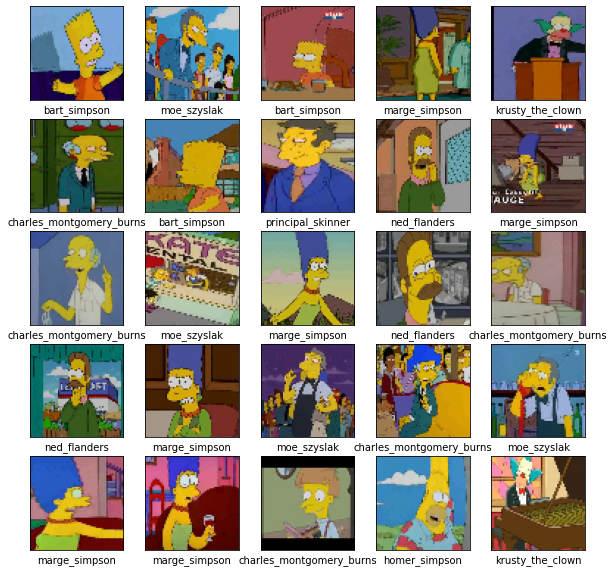

In [0]:
class_names = ['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson',
     'charles_montgomery_burns', 'chief_wiggum', 'comic_book_guy', 'edna_krabappel', 
     'homer_simpson',  'kent_brockman',  'krusty_the_clown',  'lisa_simpson', 
     'marge_simpson', 'milhouse_van_houten',  'moe_szyslak', 
    'ned_flanders',  'nelson_muntz', 'principal_skinner',  'sideshow_bob']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(class_names[labels[i]])

In [0]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        width_shift_range=0.1,  
        height_shift_range=0.1, 
        horizontal_flip=True,  
        vertical_flip=False)

In [0]:
datagen.fit(X_train)

Con ImageDataGenerator generamos un conjunto de imágenes que toman las que están disponibles en el conjunto X_train y las reflejan en el eje vertical para generar más datos que serán útiles en el entrenamiento, aplicando la técnica de data augmentation.

**Construimos el modelo de CNN**

In [0]:
# Definición del modelo
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',activation='relu', input_shape=input_shape))

model.add(Conv2D(32, (3, 3),activation='relu'))

model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))

model.add(Conv2D(64, (3, 3),activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(256, (3, 3), padding='same',activation='relu')) 

model.add(Conv2D(256, (3, 3),activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))


model.add(Dense(num_clases, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 64)         

In [0]:
from keras.optimizers import Adam, SGD
# Compilamos el modelo
model.compile(loss='categorical_crossentropy',optimizer=SGD(lr=0.009, decay=1e-6, momentum=0.9, nesterov=True),metrics=['accuracy'])

#history3 = model.fit(X, y,
 #                   batch_size = batch_size,
  #                  epochs = epochs,
   #                 validation_data = (X_val, y_val))

history3 = model.fit_generator(datagen.flow(X_train,y_train, batch_size=128),
                              steps_per_epoch=len(X_train) / 32, 
                              epochs=epochs,validation_data=(X_val, y_val),
                              nb_val_samples=0.2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=474.8125, epochs=30, validation_data=(array([[[..., validation_steps=0.2)`
  del sys.path[0]


Epoch 1/30
475/474 [==============================] - 67s 140ms/step - loss: 2.4078 - accuracy: 0.2551 - val_loss: 1.6409 - val_accuracy: 0.5105
Epoch 2/30
475/474 [==============================] - 61s 128ms/step - loss: 1.3836 - accuracy: 0.5819 - val_loss: 0.8648 - val_accuracy: 0.7401
Epoch 3/30
475/474 [==============================] - 60s 127ms/step - loss: 0.8841 - accuracy: 0.7313 - val_loss: 0.6551 - val_accuracy: 0.7975
Epoch 4/30
475/474 [==============================] - 61s 128ms/step - loss: 0.6429 - accuracy: 0.8028 - val_loss: 0.5204 - val_accuracy: 0.8404
Epoch 5/30
475/474 [==============================] - 63s 132ms/step - loss: 0.5112 - accuracy: 0.8410 - val_loss: 0.4550 - val_accuracy: 0.8628
Epoch 6/30
475/474 [==============================] - 61s 128ms/step - loss: 0.4078 - accuracy: 0.8732 - val_loss: 0.4030 - val_accuracy: 0.8820
Epoch 7/30
475/474 [==============================] - 61s 128ms/step - loss: 0.3412 - accuracy: 0.8930 - val_loss: 0.4135 - val_ac

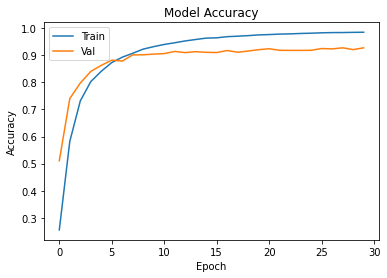

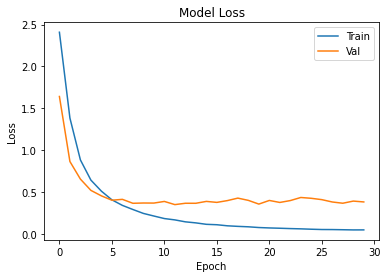

In [0]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()


plt.subplot(1,1,1)
plot_acc(history3)


plt.subplot(1,1,1)
plot_loss(history3)

Finalmente, los resultados de evaluar el modelo en el dataset de test son:

In [0]:
score = model.evaluate(X_t, y_t)
print('Loss:', score[0])
print('Accuracy:', score[1])

890/890 [==============================] - 0s 219us/step
Loss: 0.07712615481733143
Accuracy: 0.9876404404640198


**Análisis de resultados, obtención de métricas de precision y recall por clase y análisis de qué clases obtienen mejores o peores resultados**

Las clases que mejores resultados obtuvieron en la métrica de precision fueron las clases: 0, 1, 4, 5, 6, 8, 9, 11, 14, 15, 16 con un 1.00 cada una, y las clases con los peores resultados fueron las clases: 12 con 0.96 y la clase 17 con 0.92 de precision.
Por otra parte, las clases que obtuvieron mejores resultados en recall fueron: 0, 7, 8, 9, 12, 13, 14, 16, 17 todas con un recall de 1.00; así mismo las clases 4, 6 obtuvieron el peor rendimiento con 0.96 de recall.

In [0]:
# Importamos las librerías necesarias para crear la matriz de confusión
from sklearn.metrics import confusion_matrix, classification_report  
import numpy as np
import pandas as pd

In [0]:
# Realizando una predicción sobre el dataset de validación
model_pred = model.predict(X_t, batch_size=32, verbose=1)  
model_predicted = np.argmax(model_pred, axis=1) 

890/890 [==============================] - 0s 117us/step


In [0]:
# Generar la matriz de confusión
model_cm = confusion_matrix(np.argmax(y_t, axis=1), model_predicted)

In [0]:
# imprimir las métricas resultantes por cada clase
model_report = classification_report(np.argmax(y_t, axis=1), model_predicted)  
print(model_report)  

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      0.98      0.99        50
           2       0.98      0.98      0.98        50
           3       0.98      0.98      0.98        48
           4       1.00      0.96      0.98        50
           5       1.00      0.98      0.99        49
           6       1.00      0.96      0.98        50
           7       0.98      1.00      0.99        50
           8       1.00      1.00      1.00        50
           9       1.00      1.00      1.00        50
          10       0.98      0.98      0.98        50
          11       1.00      0.98      0.99        50
          12       0.96      1.00      0.98        49
          13       0.98      1.00      0.99        50
          14       1.00      1.00      1.00        49
          15       1.00      0.98      0.99        50
          16       1.00      1.00      1.00        50
          17       0.92    

**Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?**

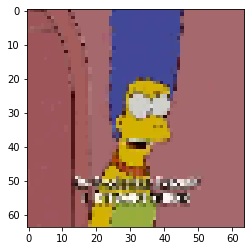

In [0]:
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(X[54], cv2.COLOR_BGR2RGB))
plt.show()

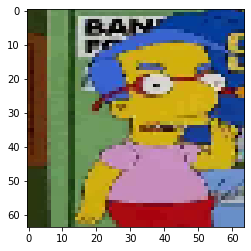

In [0]:
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(X[72], cv2.COLOR_BGR2RGB))
plt.show()

Las dos cateogrías que representan más problemas, son la de Marge y Milhouse, puede deberse a su característico cabello azúl, que si no se cuenta con una cantidad suficiente de datos, puede confundir a la red

**Comparación de modelos CNNs con un modelo de Fully Connected para este problema**

Al realizar la comparación de nuestro modelo CNN con una red Fully Connected con más del doble de parámetros (~13M vs ~6M de la CNN) de cuatro capas densas más la capa final softmax. Obsevamos que realizando el entrenamiento con 20 épocas, los resultados del modelo Fully Connected son muy inferiores a los del modelo CNN, alcanzando una accuracy menor al 50%.

In [0]:
# Redimensionamos los datos de entrada para que sean entendidos por el algoritmo
X_train = X_train.reshape(X_train.shape[0], IMG_SIZE*IMG_SIZE*3)
X_val = X_val.reshape(X_val.shape[0], IMG_SIZE*IMG_SIZE*3)
X_t = X_t.reshape(X_t.shape[0], IMG_SIZE*IMG_SIZE*3)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_t = X_t.astype('float32')

In [0]:
# Definición del modelo
model = Sequential()
model.add(Dense(1024, activation='relu',input_shape=(IMG_SIZE*IMG_SIZE*3,)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_clases, activation='softmax')) # Capa final softmax
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1024)              12583936  
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 18)               

In [0]:
# Compilamos el modelo
model.compile(loss = 'categorical_crossentropy',
               optimizer = keras.optimizers.Adadelta(),
               metrics = ['accuracy'])

history5 = model.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = 20,
                    validation_data = (X_val, y_val))

Train on 15194 samples, validate on 3798 samples
Epoch 1/20
15194/15194 [==============================] - 4s 259us/step - loss: 2.8998 - accuracy: 0.1180 - val_loss: 2.6719 - val_accuracy: 0.1538
Epoch 2/20
15194/15194 [==============================] - 2s 141us/step - loss: 2.6346 - accuracy: 0.1732 - val_loss: 2.5365 - val_accuracy: 0.2401
Epoch 3/20
15194/15194 [==============================] - 2s 143us/step - loss: 2.4631 - accuracy: 0.2404 - val_loss: 2.3523 - val_accuracy: 0.2491
Epoch 4/20
15194/15194 [==============================] - 2s 142us/step - loss: 2.3320 - accuracy: 0.2829 - val_loss: 2.2343 - val_accuracy: 0.3144
Epoch 5/20
15194/15194 [==============================] - 2s 142us/step - loss: 2.1891 - accuracy: 0.3286 - val_loss: 2.1071 - val_accuracy: 0.3431
Epoch 6/20
15194/15194 [==============================] - 2s 142us/step - loss: 2.1320 - accuracy: 0.3496 - val_loss: 2.0714 - val_accuracy: 0.3599
Epoch 7/20
15194/15194 [==============================] - 2s 14

In [0]:
score = model.evaluate(X_t, y_t)
print('Loss:', score[0])
print('Accuracy:', score[1])

890/890 [==============================] - 0s 97us/step
Loss: 1.7915734955434048
Accuracy: 0.45730337500572205


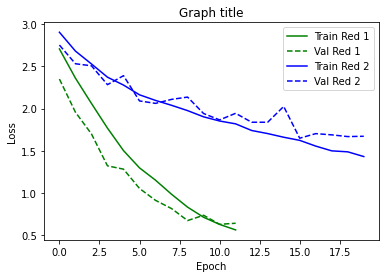

In [0]:
plot_compare_losses(history3, history5)

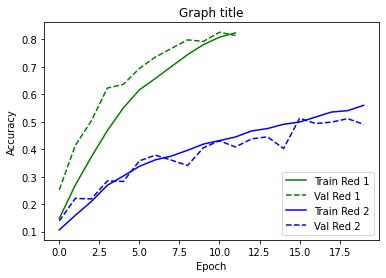

In [0]:
plot_compare_accs(history3, history5)

La comparativa entre los dos modelos, es que la **CNN** tiene un Loss de 0.077126 y Accuracy de 0.987640, mientras que una red **DNN**, tiene un Loss de 1.791573 y Accuracy de 0.457307, lo que evidencia una diferencia enorme entre procesar las redes convolucionales con una red profunda simple y una red convolucional

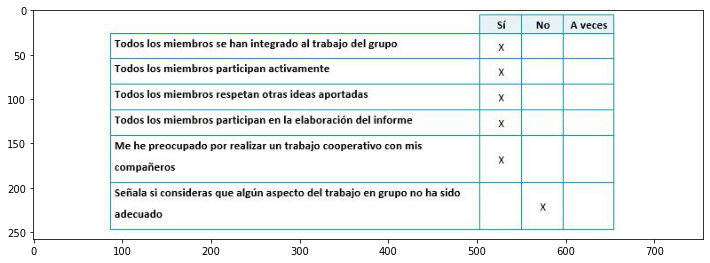

In [8]:
import matplotlib.pyplot as plt
image = plt.imread('califi.jpeg')
plt.figure(figsize = (12,12))
plt.imshow(image)